In [11]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jinquan_cc_sample_data_path = kagglehub.dataset_download('jinquan/cc-sample-data')

print('Data source import complete.')
print(jinquan_cc_sample_data_path)


Data source import complete.
/root/.cache/kagglehub/datasets/jinquan/cc-sample-data/versions/1


In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data_path = '/root/.cache/kagglehub/datasets/jinquan/cc-sample-data/versions/1/cc_sample_transaction.json'
import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/jinquan/cc-sample-data/versions/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/jinquan/cc-sample-data/versions/1/cc_sample_transaction.json


In [15]:
!pip install pyspark

In [16]:
!pip install ydata_profiling

## Basics Importing

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *


spark = SparkSession.builder \
    .appName("CreditCardTransactions") \
    .getOrCreate()

df = spark.read.json(data_path)

## Basics Profiling

In [18]:
from ydata_profiling import ProfileReport
print("===== DataFrame Schema =====")
df.printSchema()

print("\n===== Sample Data =====")
df.show(5, truncate=False,vertical=True)

print("\n===== Summary Statistics =====")
df.describe().show(vertical=True)

df_sample = df.limit(10000).toPandas()

# print("\n===== Generating Auto-Profiling Report =====")
# profile = ProfileReport(df_sample, title="Credit Card Transactions Profiling Report", explorative=True)
# profile.to_file("/kaggle/working/data_profiling_report.html")

# print("Auto-profiling report saved as 'data_profiling_report.html'.")

===== DataFrame Schema =====
root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)


===== Sample Data =====
-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Column Parsing and Formatting
Since `personal_detail` is a json string, I have to parse it using `StructType`
Finally, I flatten all parsed fields into a huge dataframe object with the destructured columns.

In [19]:
personal_schema = StructType([
    StructField("person_name", StringType()),
    StructField("gender", StringType()),
    StructField("address", StringType()),
    StructField("lat", StringType()),
    StructField("long", StringType()),
    StructField("city_pop", StringType()),
    StructField("job", StringType()),
    StructField("dob", StringType())
])

address_schema = StructType([
    StructField("street", StringType()),
    StructField("city", StringType()),
    StructField("state", StringType()),
    StructField("zip", StringType())
])

df = df.withColumn("personal_detail", from_json(col("personal_detail"), personal_schema)) \
       .withColumn("address", from_json(col("personal_detail.address"), address_schema))

df = df.select(
    col("Unnamed: 0").alias("id"),
    col("trans_date_trans_time"),
    col("cc_num"),
    col("merchant"),
    col("category"),
    col("amt"),
    col("personal_detail.person_name").alias("person_name"),
    col("personal_detail.gender").alias("gender"),
    col("address.street").alias("street"),
    col("address.city").alias("city"),
    col("address.state").alias("state"),
    col("address.zip").alias("zip"),
    col("personal_detail.lat").alias("lat"),
    col("personal_detail.long").alias("long"),
    col("personal_detail.city_pop").alias("city_pop"),
    col("personal_detail.job").alias("job"),
    col("personal_detail.dob").alias("dob"),
    col("trans_num"),
    col("merch_lat"),
    col("merch_long"),
    col("is_fraud"),
    col("merch_zipcode"),
    col("merch_last_update_time"),
    col("merch_eff_time"),
    col("cc_bic")
)

## For handling PII Data

For PII Data, there are several ways to handle them.
1. I can either mask them with mask string '**** 1243'
2. Hash the field.

I choose to hash the column because it's reversible and I can get decode the original data.

In [20]:
# Handle PII Data (Hashing Sensitive Columns)
pii_columns = ["cc_num", "street", "dob", "job"]

for column in pii_columns:
    df = df.withColumn(column, sha2(col(column), 256))



df = df.withColumn("person_name_cleaned", regexp_replace(col("person_name"), "[^a-zA-Z]", ",")) \
       .withColumn("tmp_split", split(col("person_name_cleaned"), ",")) \
       .withColumn("first", trim(col("tmp_split")[0])) \
       .withColumn("last", trim(col("tmp_split")[1])) \
       .drop("tmp_split", "person_name", "person_name_cleaned")

df = df.withColumn("first", sha2(col("first"), 256)) \
       .withColumn("last", sha2(col("last"), 256))

## Handling Timestamps
I cast everything into timestamp then convert to TC+8

In [21]:
# Convert Timestamps to UTC+8
df = df.withColumn("trans_date_trans_time",
                   from_utc_timestamp(to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss"), "UTC+8"))

df = df.withColumn("merch_last_update_time",
                   from_utc_timestamp(from_unixtime(col("merch_last_update_time").cast("double")/1000), "UTC+8")) \
       .withColumn("merch_eff_time",
                   from_utc_timestamp(from_unixtime(col("merch_eff_time").cast("double")/1e6), "UTC+8"))

# Data Quality Cleaning
Here, I choose to drop rows where is_fraud is null. This is simply for data quality checks, and for further visualization for meaningful insights.
Otherwise, we can choose to not drop the rows too.

In [22]:
# Data Quality
df = df.withColumn("amt", col("amt").cast("double")) \
       .withColumn("city_pop", col("city_pop").cast("integer"))

df = df.withColumn("is_fraud", when(col("is_fraud").isin(["0", "1"]), col("is_fraud")).otherwise(None))

df = df.na.drop(subset=["cc_num", "amt", "is_fraud"])

## For the visualization
Since some fields are hashed for PII purpose, I choose to focus on the fraud distribution statistics.
From the visualization below we can see most of the transaction are non-fraudulent.
Also, transaction amount of fraudulent transaction greatly exceeds non-fraudulent ones.

In [23]:
fraud_counts = df.groupBy("is_fraud").count().toPandas()

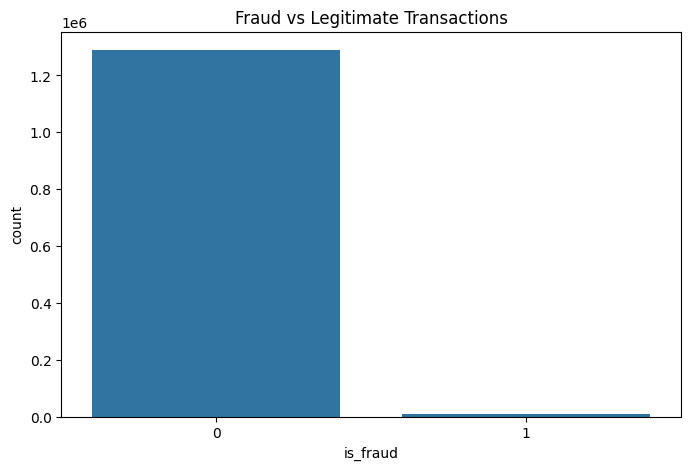

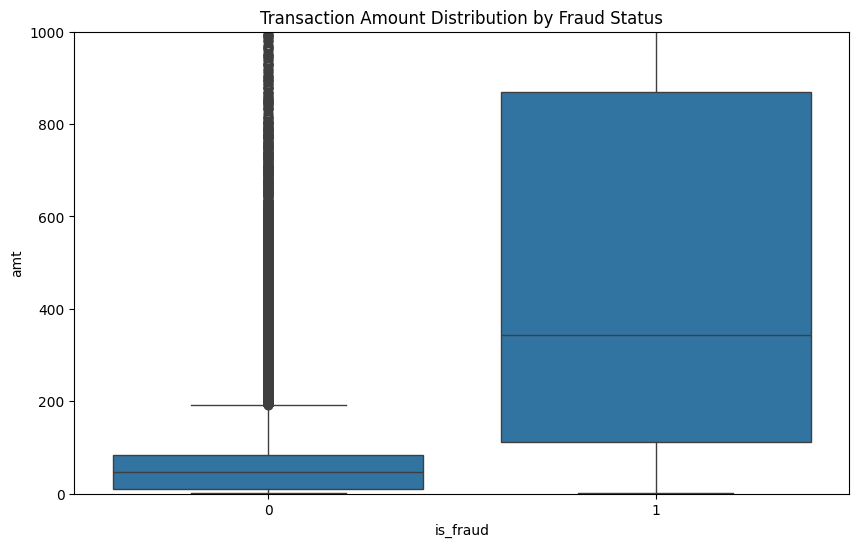

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x='is_fraud', y='count', data=fraud_counts)
plt.title("Fraud vs Legitimate Transactions")
plt.show()

amt_stats = df.groupBy("is_fraud").agg(mean("amt"), stddev("amt")).toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='amt', data=df.sample(0.1).toPandas())
plt.ylim(0, 1000)
plt.title("Transaction Amount Distribution by Fraud Status")
plt.show()

## More data quality and integrity checks
We can specify more constraints in the pipeline, and log the errors.

Due to time constraints, this is not fully integrated in the pipeline.

In [25]:
from pyspark.sql.functions import col, when, lit
from functools import reduce

validation_rules = {
    "cc_num": col("cc_num").rlike(r"^\d{16}$"),  # Must be 16 digits
    "amt": col("amt") > 0,  # Must be positive
    "is_fraud": col("is_fraud").isin(["0", "1"]),  # Must be 0 or 1
    "dob": col("dob").rlike(r"^\d{4}-\d{2}-\d{2}$"),  # Must be a valid date format
    "city_pop": col("city_pop") >= 0,  # Must be non-negative
    "lat": (col("lat").cast("double").between(-90, 90)),  # Must be valid latitude
    "long": (col("long").cast("double").between(-180, 180))  # Must be valid longitude
}


validation_condition = reduce(
    lambda a, b: a & b,
    [when(rule, lit(True)).otherwise(lit(False)) for rule in validation_rules.values()]
)

error_log = df.select("*").where(~validation_condition)


error_count = error_log.count()
print(f"Number of rows with errors: {error_count}")

error_log.show(5)

Number of rows with errors: 1296675
+---+---------------------+--------------------+--------------------+-------------+------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+--------------------+--------------------+------------------+-----------+--------+-------------+----------------------+-------------------+-----------+--------------------+--------------------+
| id|trans_date_trans_time|              cc_num|            merchant|     category|   amt|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|                 dob|           trans_num|         merch_lat| merch_long|is_fraud|merch_zipcode|merch_last_update_time|     merch_eff_time|     cc_bic|               first|                last|
+---+---------------------+--------------------+--------------------+-------------+------+------+--------------------+--------------+-----+-----+-------+---------+--------+------------------